In [1]:
### Author: Leonie Küchenhoff
### Date: October 2022
### Purpose of script: 
### 1. Plot total number of tissue specific and common variants

In [2]:
# package import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from config import basedir, outdir
from sklearn.linear_model import LinearRegression
import scipy

In [3]:
# directory settings
os.chdir(basedir)
outdir = str(outdir + '/AF/')
print('This base directory will be used:\n', basedir)
os.chdir(basedir)

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/02_rnaseq/snakemake/


In [4]:
# define filtering method (will only be used in saving of plots)
filter = '1ed'
# define sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
based_editor = ['pbs', 'pbs', 'pbs', '8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']
# mutation of each sample
mutation = ['r636q' if i[-1] == 'R' else 'p635l' for i in names]
# confition (mutation & treatment) per sample
condition = [i+'_'+j for i,j in zip(based_editor, mutation)]

# Path to tissue specific variants
paths_spec = [f'filtered_tables/HL{i}.specific.annofilter.txt' for i in names]
# Path to all filtered variants
paths = [f'filtered_tables/HL{i}.tisoverlap.annofilter.txt' for i in names]
# column names containing AD values for both tissues
col1 = 'ad_h'
col2 = 'ad_l'

In [5]:
# read in filtered data and exclude X / Y chromosome
file_dict = {}
for i in zip(paths_spec, names):
    df = pd.read_csv(i[0], delimiter = '\t')
    file_dict[i[1]] = df[(df['chr'] != 'chrY') & (df['chr'] != 'chrX')]

In [6]:
def get_sets(df):
    '''
    function that returns the df with de novo variants and list of indices with de novo variants in heart& liver
    '''
    unknown = df[(df['known_dbsnp']== False) & (df['known_mgp'] == False)]
    setlist = np.arange(0, len(unknown))
    heart = setlist[unknown['heart']]
    liver = setlist[unknown['liver']]
    return heart, liver, unknown

In [7]:
venn_dict = {}
for i in names:
    venn_dict[i] = get_sets(file_dict[i])

### Heart specific variants

In [8]:
heart_spec_dict = {}
for i in names:
    df = venn_dict[i][2][(venn_dict[i][2]['heart'] == True)]
    heart_spec_dict[i] = df


### Liver specific variants

In [9]:
liver_spec_dict = {}
for i in names:
    df = venn_dict[i][2][(venn_dict[i][2]['liver'] == True)]
    liver_spec_dict[i] = df


### Common overlap three tissues

In [10]:
def get_af(df, col1 = 'AD|h_mu', col2 = 'AD|l_mu'):
    mouse_ad = df[[col1, col2]]
    allel1 = mouse_ad.applymap(lambda x: int(x.split(',')[0]) if pd.notnull(x) else 2).to_numpy()
    allel2 = mouse_ad.applymap(lambda x: int(x.split(',')[1]) if pd.notnull(x) else -1).to_numpy()
    af = allel2 / (allel1 + allel2)
    af = np.nan_to_num(af, 0)
    return af

In [11]:
# read in filtered data and exclude X / Y chromosome
file_dict_comm = {}
for i in zip(paths, names):
    df = pd.read_csv(i[0], delimiter = '\t')
    file_dict_comm[i[1]] = df[(df['chr'] != 'chrY') & (df['chr'] != 'chrX')]

venn_dict_comm = {}
for i in names:
    venn_dict_comm[i] = get_sets(file_dict_comm[i])

In [12]:
# filter for variants present in all three tissues
common_dict = {}
for i in names:
    df = venn_dict_comm[i][2]
    common_dict[i] = df

In [13]:
len_dict = {}
for i in names:
    # get number of variants
    len_dict[i] = [len(heart_spec_dict[i]),len(liver_spec_dict[i]),len(common_dict[i])]

In [14]:
# summarize data into one adtaframe for plotting
df_plot = df.from_dict(len_dict).T
df_plot['base_editor'] = based_editor
df_plot['mutation'] = mutation
df_plot = df_plot.reset_index(level=0).rename(columns ={0:'heart', 1:'liver', 2:'common', 'index' :'sample'}).melt(id_vars = ['sample', 'base_editor', 'mutation'], var_name = 'tissue')

In [15]:
# plotting settings
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

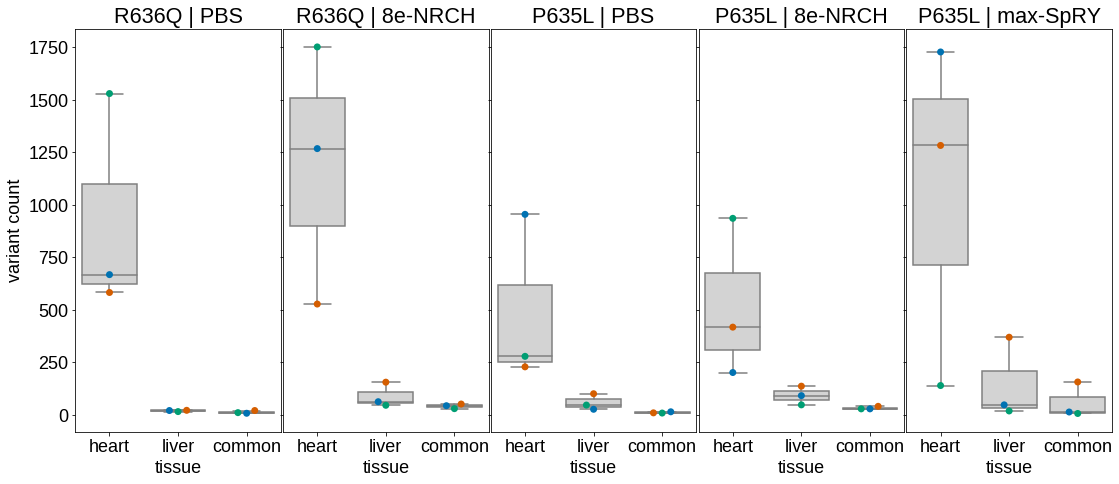

In [16]:
fig, axs = plt.subplots(1,5, figsize = (18,7), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

data = df_plot[(df_plot['base_editor'] == '8e-NRCH') & (df_plot['mutation'] == 'r636q')]

sns.boxplot(x = 'tissue', y = 'value', data = data, color = 'lightgrey', ax = axs[1])
sns.swarmplot(x = 'tissue', y = 'value', data = data, hue = 'sample', size = 7, ax = axs[1])


data = df_plot[(df_plot['base_editor'] == 'pbs') & (df_plot['mutation'] == 'r636q')]

sns.boxplot(x = 'tissue', y = 'value', data = data, color = 'lightgrey', ax = axs[0])
sns.swarmplot(x = 'tissue', y = 'value', data = data, hue = 'sample', size = 7, ax = axs[0])


data = df_plot[(df_plot['base_editor'] == '8e-NRCH') & (df_plot['mutation'] == 'p635l')]

sns.boxplot(x = 'tissue', y = 'value', data = data, color = 'lightgrey', ax = axs[3])
sns.swarmplot(x = 'tissue', y = 'value', data = data, hue = 'sample', size = 7, ax = axs[3])


data = df_plot[(df_plot['base_editor'] == 'max-SpRY') & (df_plot['mutation'] == 'p635l')]

sns.boxplot(x = 'tissue', y = 'value', data = data, color = 'lightgrey', ax = axs[4])
sns.swarmplot(x = 'tissue', y = 'value', data = data, hue = 'sample', size = 7, ax = axs[4])

data = df_plot[(df_plot['base_editor'] == 'pbs') & (df_plot['mutation'] == 'p635l')]

sns.boxplot(x = 'tissue', y = 'value', data = data, color = 'lightgrey', ax = axs[2])
sns.swarmplot(x = 'tissue', y = 'value', data = data, hue = 'sample', size = 7, ax = axs[2])

for ax in axs:
    ax.set_ylabel('')
    ax.set_xlabel('tissue')
    ax.get_legend().remove()

axs[1].set_title('R636Q | 8e-NRCH')
axs[0].set_title('R636Q | PBS')
axs[3].set_title('P635L | 8e-NRCH')
axs[4].set_title('P635L | max-SpRY')
axs[2].set_title('P635L | PBS')
axs[0].set_ylabel('variant count')
fig.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.01,
                    hspace=0.4)

plt.show()

# save plot and data

fig.savefig(f'{outdir}/number_variants_noyx_anno_read_filter.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/number_variants_noyx_anno_read_filter.svg', bbox_inches = 'tight')
save = df_plot.rename(columns = {'value': 'count', 'variable': 'sample'})
save.to_csv(f'{outdir}/tissue_spec_variantnumbers.csv', index = None)
